<a href="https://colab.research.google.com/github/dinithprimal/DeepLearning_Tutorials/blob/main/EX23_Text_Classification_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_text

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [6]:
import pandas as pd

df = pd.read_csv('spam.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

This is a imbalance dataset

## Using Downsampling Method

In [8]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

In [10]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [11]:
df_ham.sample(2)

,Category,Message
5385,ham,How do friends help us in problems? They give ...
2058,ham,"Nothing, i got msg frm tht unknown no.."


In [12]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [13]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [14]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [15]:
df_balanced.sample(5)

,Category,Message
531,spam,PRIVATE! Your 2003 Account Statement for 07815...
4277,ham,Can you please send me my aunty's number
4278,ham,I'm glad. You are following your dreams.
160,spam,You are a winner U have been specially selecte...
2824,ham,Then u ask darren go n pick u lor... But i oso...


In [16]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
4543,spam,FreeMsg Hi baby wow just got a new cam moby. W...,1
59,ham,Yes..gauti and sehwag out of odi series.,0
3420,spam,Do you want a new Video phone? 600 anytime any...,1
4054,ham,I was slept that time.you there?,0
2310,ham,"I have 2 sleeping bags, 1 blanket and paper an...",0
3556,spam,From next month get upto 50% More Calls 4 Ur s...,1
191,spam,Are you unique enough? Find out from 30th Augu...,1
4686,ham,"Alright we'll bring it to you, see you in like...",0
1778,spam,Buy Space Invaders 4 a chance 2 win orig Arcad...,1
3289,spam,Someone U know has asked our dating service 2 ...,1


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'])

In [18]:
X_train.head(4)

5475    Dhoni have luck to win some big title.so we wi...
788     Ever thought about living a good life with a p...
2029               Kallis is ready for bat in 2nd innings
5196    Spook up your mob with a Halloween collection ...
Name: Message, dtype: object

In [19]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [20]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    "500$ discount! hurry up",
    "Dinith, are you up for a cricket match tomorrow?"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8873615 , -0.51289356, -0.79252255, ..., -0.51586   ,
        -0.72764117,  0.92980576],
       [-0.80930966, -0.40690136, -0.87955743, ..., -0.78093994,
        -0.63844806,  0.85065585]], dtype=float32)>

In [21]:
e = get_sentence_embedding([
    'banana',
    'grapes',
    'mango',
    'jeff bezos',
    'elon musk',
    'bill gates'
])

In [22]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606916 , -0.1421939 ,  0.4960467 , ...,  0.42165366,
        -0.5322139 ,  0.80312145],
       [-0.86023206, -0.21242917,  0.49156943, ...,  0.3979806 ,
        -0.6050627 ,  0.8447165 ],
       [-0.7128858 , -0.15463899,  0.38401696, ...,  0.35278735,
        -0.50991327,  0.7347407 ],
       [-0.8253348 , -0.3555059 , -0.5906971 , ..., -0.01613699,
        -0.6141758 ,  0.8723029 ],
       [-0.750413  , -0.26812592, -0.2668958 , ...,  0.02839475,
        -0.59380937,  0.79749817],
       [-0.7854431 , -0.29949626,  0.41027677, ...,  0.5222551 ,
        -0.4957349 ,  0.81507415]], dtype=float32)>

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]], [e[1]])

array([[0.9911087]], dtype=float32)

In [24]:
cosine_similarity([e[0]], [e[2]])

array([[0.9954097]], dtype=float32)

In [25]:
cosine_similarity([e[0]], [e[3]])

array([[0.8470381]], dtype=float32)

In [26]:
cosine_similarity([e[0]], [e[4]])

array([[0.8933631]], dtype=float32)

## Model Creation

In [27]:
# BERT Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_test = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_test)

# Neural Network Layer
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)


# COnstruct the final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [29]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[METRICS]
)

In [30]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 21s 312ms/step - loss: 0.6400 - accuracy: 0.6420 - precision: 0.6593 - recall: 0.5875
Epoch 2/10
35/35 [==============================] - 11s 316ms/step - loss: 0.5054 - accuracy: 0.8304 - precision: 0.8043 - recall: 0.8732
Epoch 3/10
35/35 [==============================] - 11s 315ms/step - loss: 0.4414 - accuracy: 0.8580 - precision: 0.8536 - recall: 0.8643
Epoch 4/10
35/35 [==============================] - 11s 318ms/step - loss: 0.4024 - accuracy: 0.8705 - precision: 0.8584 - recall: 0.8875
Epoch 5/10
35/35 [==============================] - 11s 321ms/step - loss: 0.3657 - accuracy: 0.8875 - precision: 0.8617 - recall: 0.9232
Epoch 6/10
35/35 [==============================] - 13s 386ms/step - loss: 0.3482 - accuracy: 0.8759 - precision: 0.8491 - recall: 0.9143
Epoch 7/10
35/35 [==============================] - 12s 336ms/step - loss: 0.3267 - accuracy: 0.8813 - precision: 0.8687 - recall: 0.8982
Epoch 8/10
35/35 [================

In [31]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 333ms/step - loss: 0.2766 - accuracy: 0.9171 - precision: 0.9333 - recall: 0.8984


[0.2766040563583374,
 0.9171122908592224,
 0.9333333373069763,
 0.8983957171440125]

In [32]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 4s 320ms/step


In [33]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[175,  12],
       [ 19, 168]])

Text(50.722222222222214, 0.5, 'Truth')

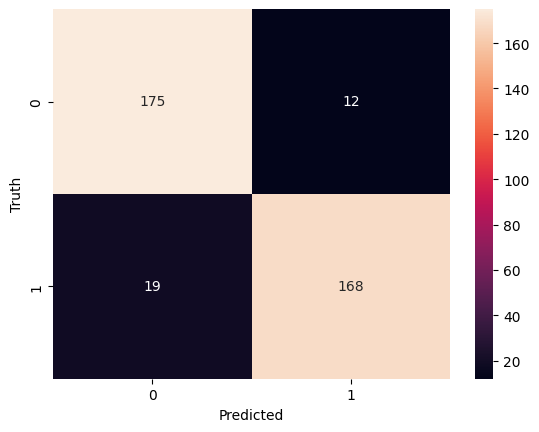

In [36]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [37]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       187
           1       0.93      0.90      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



## Inference

In [39]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valued untill match 31, 2021',
    'you are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery with 28 days.',
    'It to 80488. Your 500 free text messages are valid until 31st December 2005',
    'Hey Sam, Are you comming for a crcket mathch tommorow',
    'Why do not you wait till at least wednesday to see if you get in',
]

model.predict(reviews)

1/1 [==============================] - 0s 78ms/step


array([[0.8252711 ],
       [0.76438993],
       [0.77326316],
       [0.09560822],
       [0.15991278]], dtype=float32)